## Fine-tuning CNNs for Classification Exercise
In this exercise, we'll focus on how to take an existing CNN architecture with weights that have been optimized for a general image classification task, and fine-tune it for a specific medical imaging task.

We'll work with the VGG16 architecture, using weights that have been trained in ImageNet. We'll walk through three different ways to use its architecture and fine-tune it to be used for classification of dense vs. fatty breast tissue on mammogram images.

#### The three scenarios for you to try are the following:
* Freeze all layers except for the final convolutional layer of VGG16
* Freeze all layers except the final convolutional layer of VGG16, and add several dense (fully connected) layers
* Freeze all layers except the final convolutional layer of VGG16, and add several dense (fully connected) layers with dropout

### Note: 
the purpose of this exercise is not to get great performance. We are not providing you nearly enough training and testing data for that. The purpose of this exercise is to get familiar with different ways to fine-tune existing architectures. To that end, just run each model architecture for 5 epochs or so with the small amount of training and validation data.



In [2]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io
import seaborn as sns
# Set seaborn style
sns.set_theme()
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [3]:
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('test.csv')

## Setting up the image augmentation from last Lesson: 
Note that this section of the code has been pre-written for you and does not need to be changed, just run. If you would like to change the ImageDataGenerator parameters, feel free.

In [4]:
## This is the image size that VGG16 takes as input
IMG_SIZE = (224, 224)

In [5]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

# Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 6) ## We've only been provided with 6 validation images

Found 20 validated image filenames belonging to 2 classes.
Found 6 validated image filenames belonging to 2 classes.


In [6]:
## Pull a single large batch of random validation data for testing after each epoch
testX, testY = val_gen.next()

## Now we'll load in VGG16 with pre-trained ImageNet weights: 

In [7]:
model = VGG16(include_top=True, weights='imagenet')
model.summary()

2022-04-06 13:30:08.584320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-06 13:30:08.584594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (N

In [8]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [9]:
## Now, choose which layers of VGG16 we actually want to fine-tune
## Here, we'll freeze all but the last convolutional layer

## Add some code here to freeze all but the last convolutional layer:
##### Your code here ######
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [10]:
## Check to make sure you froze the right ones: 
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


## Build a simple sequential model using only the VGG16 architecture
Note the code in the cell below has been pre-written for you, you only need to run it

In [11]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1, activation='sigmoid'))

In [12]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(learning_rate=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [13]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [14]:
## Just run a single epoch to see how it does:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

/var/folders/v_/rh4ycfcn3vd4r73j2nln2brm0000gn/T/ipykernel_7564/1838731346.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_gen,
2022-04-06 13:30:20.109454: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-04-06 13:30:20.355190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 1.2499 - binary_accuracy: 0.5000

2022-04-06 13:30:23.180634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 462ms/step - loss: 1.2499 - binary_accuracy: 0.5000 - val_loss: 1.0053 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 1s 205ms/step - loss: 0.8425 - binary_accuracy: 0.5000 - val_loss: 0.6717 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 1s 199ms/step - loss: 0.6670 - binary_accuracy: 0.4000 - val_loss: 0.6488 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 1s 197ms/step - loss: 0.6481 - binary_accuracy: 0.5000 - val_loss: 0.6546 - val_binary_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 1s 195ms/step - loss: 0.5811 - binary_accuracy: 0.5000 - val_loss: 0.6220 - val_binary_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 1s 161ms/step - loss: 0.4879 - binary_accuracy: 0.7500 - val_loss: 0.5834 - val_binary_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 1s 161ms/step - loss: 0.4936 - binary

## Let's try another experiment where we add a few more dense layers:

In [15]:
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

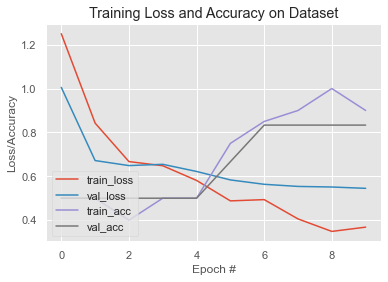

In [16]:
plot_history(history)

In [17]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [18]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
## Just run a single epoch to see how it does:
new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 5)

/var/folders/v_/rh4ycfcn3vd4r73j2nln2brm0000gn/T/ipykernel_7564/1829231215.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  new_model.fit_generator(train_gen,


Epoch 1/5


2022-04-06 13:30:40.503045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 316ms/step - loss: 1.0340 - binary_accuracy: 0.4500 - val_loss: 0.6018 - val_binary_accuracy: 0.6667


2022-04-06 13:30:41.652821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/5
3/3 [==============================] - 1s 272ms/step - loss: 0.5398 - binary_accuracy: 0.6000 - val_loss: 0.6690 - val_binary_accuracy: 0.6667
Epoch 3/5
3/3 [==============================] - 1s 272ms/step - loss: 0.3359 - binary_accuracy: 0.9500 - val_loss: 0.5564 - val_binary_accuracy: 0.6667
Epoch 4/5
3/3 [==============================] - 1s 273ms/step - loss: 0.2401 - binary_accuracy: 0.8500 - val_loss: 0.6426 - val_binary_accuracy: 0.5000
Epoch 5/5
3/3 [==============================] - 1s 274ms/step - loss: 0.4163 - binary_accuracy: 0.8500 - val_loss: 0.7134 - val_binary_accuracy: 0.6667


## Now let's add dropout and another fully connected layer:

In [20]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [21]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [22]:
## Just run a single epoch to see how it does:
new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 5)

/var/folders/v_/rh4ycfcn3vd4r73j2nln2brm0000gn/T/ipykernel_7564/1829231215.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  new_model.fit_generator(train_gen,


Epoch 1/5


2022-04-06 13:30:44.841649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 256ms/step - loss: 0.8823 - binary_accuracy: 0.7000 - val_loss: 0.7073 - val_binary_accuracy: 0.5000


2022-04-06 13:30:45.703048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/5
3/3 [==============================] - 1s 191ms/step - loss: 1.9373 - binary_accuracy: 0.6000 - val_loss: 0.6548 - val_binary_accuracy: 0.8333
Epoch 3/5
3/3 [==============================] - 1s 197ms/step - loss: 1.0740 - binary_accuracy: 0.6000 - val_loss: 0.6401 - val_binary_accuracy: 0.8333
Epoch 4/5
3/3 [==============================] - 1s 193ms/step - loss: 1.1874 - binary_accuracy: 0.5000 - val_loss: 0.6357 - val_binary_accuracy: 0.6667
Epoch 5/5
3/3 [==============================] - 1s 273ms/step - loss: 0.8183 - binary_accuracy: 0.6500 - val_loss: 0.6179 - val_binary_accuracy: 0.5000


What's interesting about the small number of epochs we ran on the three different architectures above is that the simplest archiecture seemed to show the fastest learning. Why might that be? 

Answer: there were the fewest parameters to train because we didn't add any fully-connected layers, and were only fine-tuning the last layer of VGG16. 

The last architecture we tried seemed to show more stable and promise than the second, and this is likely due to the fact that we added Dropout. This helps our model from overfitting and usually using Dropout, we see better learning on the validation set (val_loss going down over epochs as opposed to only the training loss). 